In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
mpl.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False
#from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Mounted at /content/drive


In [4]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(actual_values, predicted_values):

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    # R-squared 계산
    r2 = r2_score(actual_values, predicted_values)

    return rmse, r2

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score, confusion_matrix

# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
train_data = pd.read_csv("/content/drive/MyDrive/train_seoul.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_seoul.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환 및 차원 변경
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # (batch_size, seq_len=1, input_dim)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
class TransformerRegression(nn.Module):
    def __init__(self, input_dim, output_dim, num_encoder_layers=2, nhead=4, hidden_dim=16, dropout=0.1):
        super(TransformerRegression, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.input_proj(x)  # shape: (batch_size, seq_len, hidden_dim)
        x = x.permute(1, 0, 2)  # shape: (seq_len, batch_size, hidden_dim)
        x = self.transformer_encoder(x)  # shape: (seq_len, batch_size, hidden_dim)
        x = x.mean(dim=0)  # shape: (batch_size, hidden_dim)
        x = self.fc_out(x)  # shape: (batch_size, output_dim)
        return x

In [7]:
input_dim = X_train.shape[2]
output_dim = 1
model = TransformerRegression(input_dim, output_dim).to(device)
model_1 = TransformerRegression(input_dim, output_dim).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 225.4609
Epoch [2/10], Loss: 11.7846
Epoch [3/10], Loss: 7.9360
Epoch [4/10], Loss: 5.9736
Epoch [5/10], Loss: 5.1378
Epoch [6/10], Loss: 4.9168
Epoch [7/10], Loss: 4.4562
Epoch [8/10], Loss: 4.0816
Epoch [9/10], Loss: 4.0808
Epoch [10/10], Loss: 3.8646
Test Loss: 380.6388


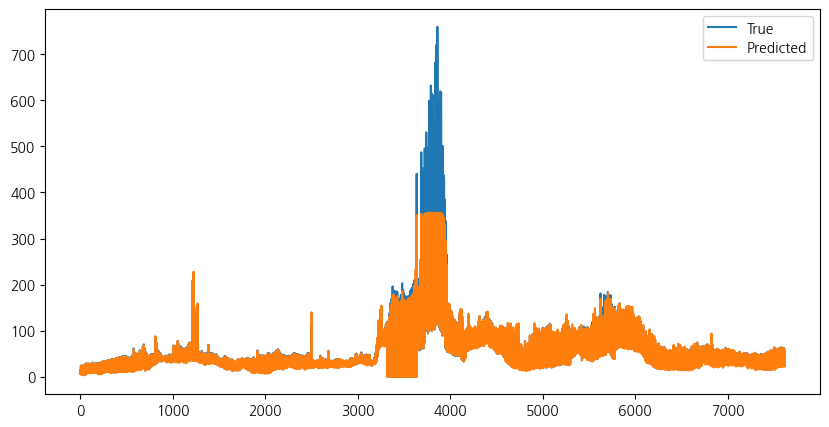

In [6]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Ensure inputs and targets are on the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 평가
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test.cpu().numpy(), label='True')
plt.plot(test_outputs.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [10]:
# 그리드 서치 함수 정의
def grid_search(model, train_data, train_label, dataloader, param_grid, input_dim, output_dim, num_epochs=15, batch_size=32):
    results = []

    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        model_1 = model(input_dim, output_dim, num_encoder_layers=params['num_encoder_layers'], nhead=params['nhead'], hidden_dim=params['hidden_dim'], dropout=params['dropout']).to(device)
        criterion = nn.MSELoss()
        optimizer = getattr(optim, params['optimizer'])(model_1.parameters(), lr=params['lr'])

        print(params)
        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            model_1.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            train_losses.append(epoch_loss)

            model_1.eval()
            test_loss = 0.0
            with torch.no_grad():
                outputs = model_1(train_data.to(device))
                test_loss = criterion(outputs, train_label.to(device)).item()
                outputs = outputs.squeeze().cpu().numpy()
                labels = train_label.cpu().numpy()
                result = evaluate_model(labels, outputs)
                sensitivity = recall_score((labels >= 81).astype(int), (outputs >= 81).astype(int)) # 바뀐 부분: 민감도 계산 추가
            test_losses.append(test_loss)
            results.append({'params': params, 'rmse': result[0], 'r2': result[1], 'sensitivity': sensitivity}) # 바뀐 부분: 민감도 결과 저장

            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Sensitivity: {sensitivity:.4f}") # 바뀐 부분: 민감도 출력

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델 선택

    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params']) # 바뀐 부분: 민감도가 가장 높은 모델의 파라미터 출력
    print("Best Sensitivity:", best_result_sensitivity['sensitivity']) # 바뀐 부분: 민감도가 가장 높은 모델의 민감도 출력

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'num_encoder_layers': [2],
    'nhead': [4, 8],
    'hidden_dim': [16, 32],
    'dropout': [0.2, 0.3],
    'optimizer': ['Adam'],
    'lr': [0.001, 0.01]
}


best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(TransformerRegression, X_train, y_train, train_loader, param_grid, X_train.shape[2], 1, num_epochs=10, batch_size=32)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


{'dropout': 0.2, 'hidden_dim': 16, 'lr': 0.001, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 229.8530, Test Loss: 22.1474, Sensitivity: 0.9995
Epoch [2/10], Train Loss: 15.3918, Test Loss: 6.5952, Sensitivity: 0.9999
Epoch [3/10], Train Loss: 9.2785, Test Loss: 7.0151, Sensitivity: 0.9998
Epoch [4/10], Train Loss: 8.6020, Test Loss: 5.9487, Sensitivity: 0.9688
Epoch [5/10], Train Loss: 8.3599, Test Loss: 10.1070, Sensitivity: 0.9897
Epoch [6/10], Train Loss: 6.9006, Test Loss: 5.0678, Sensitivity: 0.9987
Epoch [7/10], Train Loss: 6.8184, Test Loss: 4.8753, Sensitivity: 0.9998
Epoch [8/10], Train Loss: 6.8000, Test Loss: 2.7990, Sensitivity: 0.9988
Epoch [9/10], Train Loss: 6.1647, Test Loss: 3.8741, Sensitivity: 0.9996
Epoch [10/10], Train Loss: 5.9124, Test Loss: 4.4989, Sensitivity: 0.9888
{'dropout': 0.2, 'hidden_dim': 16, 'lr': 0.001, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 224.6815, Test Loss: 31.4535, Sensitivity: 0.9948
Epoch [2/10], Train Loss: 16.2952, Test Loss: 6.4163, Sensitivity: 0.9925
Epoch [3/10], Train Loss: 10.9819, Test Loss: 4.2940, Sensitivity: 0.9945
Epoch [4/10], Train Loss: 9.8401, Test Loss: 6.3468, Sensitivity: 0.9942
Epoch [5/10], Train Loss: 9.3221, Test Loss: 4.4496, Sensitivity: 0.9996
Epoch [6/10], Train Loss: 10.4937, Test Loss: 24.0465, Sensitivity: 0.9357
Epoch [7/10], Train Loss: 8.1554, Test Loss: 3.2395, Sensitivity: 0.9671
Epoch [8/10], Train Loss: 8.2304, Test Loss: 3.7785, Sensitivity: 0.9472
Epoch [9/10], Train Loss: 7.1329, Test Loss: 4.7639, Sensitivity: 0.9363
Epoch [10/10], Train Loss: 6.8658, Test Loss: 2.2147, Sensitivity: 0.9853
{'dropout': 0.2, 'hidden_dim': 16, 'lr': 0.01, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 92.4169, Test Loss: 92.8303, Sensitivity: 0.9943
Epoch [2/10], Train Loss: 84.6697, Test Loss: 22.7480, Sensitivity: 0.9837
Epoch [3/10], Train Loss: 51.7927, Test Loss: 25.6865, Sensitivity: 0.9960
Epoch [4/10], Train Loss: 49.7882, Test Loss: 19.9890, Sensitivity: 0.9998
Epoch [5/10], Train Loss: 43.1061, Test Loss: 20.0210, Sensitivity: 0.9967
Epoch [6/10], Train Loss: 37.2157, Test Loss: 26.0770, Sensitivity: 0.9948
Epoch [7/10], Train Loss: 31.7505, Test Loss: 26.2245, Sensitivity: 0.9992
Epoch [8/10], Train Loss: 32.4682, Test Loss: 37.8560, Sensitivity: 0.9980
Epoch [9/10], Train Loss: 30.2274, Test Loss: 18.9431, Sensitivity: 0.9999
Epoch [10/10], Train Loss: 29.4746, Test Loss: 35.2649, Sensitivity: 0.9987
{'dropout': 0.2, 'hidden_dim': 16, 'lr': 0.01, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 102.8190, Test Loss: 32.6576, Sensitivity: 0.6491
Epoch [2/10], Train Loss: 52.1121, Test Loss: 9.7499, Sensitivity: 0.9192
Epoch [3/10], Train Loss: 44.4370, Test Loss: 39.8272, Sensitivity: 0.9997
Epoch [4/10], Train Loss: 33.7096, Test Loss: 15.6107, Sensitivity: 0.9965
Epoch [5/10], Train Loss: 33.1039, Test Loss: 33.7800, Sensitivity: 0.9937
Epoch [6/10], Train Loss: 32.7842, Test Loss: 16.6919, Sensitivity: 0.9780
Epoch [7/10], Train Loss: 32.7683, Test Loss: 15.6522, Sensitivity: 0.9985
Epoch [8/10], Train Loss: 29.2050, Test Loss: 22.8309, Sensitivity: 0.9783
Epoch [9/10], Train Loss: 34.5093, Test Loss: 16.9350, Sensitivity: 0.9946
Epoch [10/10], Train Loss: 29.6191, Test Loss: 15.3508, Sensitivity: 0.9876
{'dropout': 0.2, 'hidden_dim': 32, 'lr': 0.001, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 157.4459, Test Loss: 20.5550, Sensitivity: 0.9995
Epoch [2/10], Train Loss: 14.7487, Test Loss: 15.8558, Sensitivity: 0.9865
Epoch [3/10], Train Loss: 11.2125, Test Loss: 5.1759, Sensitivity: 0.9991
Epoch [4/10], Train Loss: 9.5990, Test Loss: 4.1798, Sensitivity: 0.9994
Epoch [5/10], Train Loss: 8.4093, Test Loss: 7.8333, Sensitivity: 0.9993
Epoch [6/10], Train Loss: 7.7331, Test Loss: 6.0907, Sensitivity: 0.9835
Epoch [7/10], Train Loss: 6.8690, Test Loss: 1.8091, Sensitivity: 0.9765
Epoch [8/10], Train Loss: 6.5671, Test Loss: 6.6398, Sensitivity: 0.9083
Epoch [9/10], Train Loss: 5.8696, Test Loss: 3.8260, Sensitivity: 0.9987
Epoch [10/10], Train Loss: 5.9885, Test Loss: 2.7318, Sensitivity: 0.9730
{'dropout': 0.2, 'hidden_dim': 32, 'lr': 0.001, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 155.0348, Test Loss: 33.4241, Sensitivity: 0.9922
Epoch [2/10], Train Loss: 15.4402, Test Loss: 7.7018, Sensitivity: 0.9799
Epoch [3/10], Train Loss: 11.2127, Test Loss: 7.5642, Sensitivity: 0.9143
Epoch [4/10], Train Loss: 9.3602, Test Loss: 5.9077, Sensitivity: 0.9939
Epoch [5/10], Train Loss: 8.9221, Test Loss: 4.2814, Sensitivity: 0.9329
Epoch [6/10], Train Loss: 7.7689, Test Loss: 5.9867, Sensitivity: 0.9987
Epoch [7/10], Train Loss: 7.5546, Test Loss: 5.0599, Sensitivity: 0.9033
Epoch [8/10], Train Loss: 6.5585, Test Loss: 4.4624, Sensitivity: 0.9121
Epoch [9/10], Train Loss: 6.0775, Test Loss: 4.0991, Sensitivity: 0.8884
Epoch [10/10], Train Loss: 5.5465, Test Loss: 3.1574, Sensitivity: 0.9792
{'dropout': 0.2, 'hidden_dim': 32, 'lr': 0.01, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 81.3206, Test Loss: 46.9174, Sensitivity: 1.0000
Epoch [2/10], Train Loss: 39.4209, Test Loss: 44.5709, Sensitivity: 0.9975
Epoch [3/10], Train Loss: 30.4127, Test Loss: 48.2974, Sensitivity: 0.9999
Epoch [4/10], Train Loss: 25.5914, Test Loss: 40.6144, Sensitivity: 0.9999
Epoch [5/10], Train Loss: 23.1629, Test Loss: 37.2528, Sensitivity: 0.9999
Epoch [6/10], Train Loss: 20.7973, Test Loss: 27.6828, Sensitivity: 1.0000
Epoch [7/10], Train Loss: 20.2547, Test Loss: 21.3985, Sensitivity: 0.9997
Epoch [8/10], Train Loss: 18.1313, Test Loss: 14.8289, Sensitivity: 0.9996
Epoch [9/10], Train Loss: 17.9288, Test Loss: 33.1270, Sensitivity: 0.9997
Epoch [10/10], Train Loss: 17.7219, Test Loss: 33.0606, Sensitivity: 1.0000
{'dropout': 0.2, 'hidden_dim': 32, 'lr': 0.01, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 86.1464, Test Loss: 18.1258, Sensitivity: 0.9997
Epoch [2/10], Train Loss: 43.7621, Test Loss: 52.2500, Sensitivity: 0.9892
Epoch [3/10], Train Loss: 30.0197, Test Loss: 56.9775, Sensitivity: 0.9999
Epoch [4/10], Train Loss: 25.5100, Test Loss: 27.4779, Sensitivity: 0.9992
Epoch [5/10], Train Loss: 24.0747, Test Loss: 43.2648, Sensitivity: 1.0000
Epoch [6/10], Train Loss: 21.1792, Test Loss: 36.1462, Sensitivity: 0.9855
Epoch [7/10], Train Loss: 19.5168, Test Loss: 17.1773, Sensitivity: 0.9974
Epoch [8/10], Train Loss: 18.4457, Test Loss: 33.7990, Sensitivity: 0.9999
Epoch [9/10], Train Loss: 18.0639, Test Loss: 40.0516, Sensitivity: 0.9999
Epoch [10/10], Train Loss: 17.6245, Test Loss: 35.5772, Sensitivity: 0.9999
{'dropout': 0.3, 'hidden_dim': 16, 'lr': 0.001, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 235.9212, Test Loss: 58.6569, Sensitivity: 0.9993
Epoch [2/10], Train Loss: 19.3118, Test Loss: 4.6920, Sensitivity: 0.9807
Epoch [3/10], Train Loss: 7.0506, Test Loss: 2.3562, Sensitivity: 0.9920
Epoch [4/10], Train Loss: 4.1829, Test Loss: 2.6972, Sensitivity: 0.9488
Epoch [5/10], Train Loss: 3.4963, Test Loss: 2.2096, Sensitivity: 0.9946
Epoch [6/10], Train Loss: 3.0134, Test Loss: 2.3819, Sensitivity: 0.9772
Epoch [7/10], Train Loss: 2.5359, Test Loss: 2.5957, Sensitivity: 0.9759
Epoch [8/10], Train Loss: 2.8149, Test Loss: 1.5573, Sensitivity: 0.9966
Epoch [9/10], Train Loss: 2.4640, Test Loss: 1.9187, Sensitivity: 0.9861
Epoch [10/10], Train Loss: 2.8307, Test Loss: 1.0909, Sensitivity: 0.9831
{'dropout': 0.3, 'hidden_dim': 16, 'lr': 0.001, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 237.9903, Test Loss: 66.6939, Sensitivity: 0.9992
Epoch [2/10], Train Loss: 39.4519, Test Loss: 32.1359, Sensitivity: 0.9944
Epoch [3/10], Train Loss: 26.6046, Test Loss: 20.9438, Sensitivity: 0.9993
Epoch [4/10], Train Loss: 20.4689, Test Loss: 12.5960, Sensitivity: 0.9981
Epoch [5/10], Train Loss: 15.9217, Test Loss: 13.1345, Sensitivity: 0.9997
Epoch [6/10], Train Loss: 13.1916, Test Loss: 13.4946, Sensitivity: 0.9893
Epoch [7/10], Train Loss: 11.8560, Test Loss: 6.4241, Sensitivity: 0.9992
Epoch [8/10], Train Loss: 12.3660, Test Loss: 5.4434, Sensitivity: 0.9995
Epoch [9/10], Train Loss: 14.9750, Test Loss: 9.2841, Sensitivity: 0.9983
Epoch [10/10], Train Loss: 8.4226, Test Loss: 5.4122, Sensitivity: 0.9879
{'dropout': 0.3, 'hidden_dim': 16, 'lr': 0.01, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 119.7266, Test Loss: 262.3805, Sensitivity: 0.9756
Epoch [2/10], Train Loss: 85.2431, Test Loss: 35.0594, Sensitivity: 0.9992
Epoch [3/10], Train Loss: 66.5414, Test Loss: 41.4146, Sensitivity: 0.9821
Epoch [4/10], Train Loss: 58.3102, Test Loss: 67.5889, Sensitivity: 0.9999
Epoch [5/10], Train Loss: 54.7666, Test Loss: 53.4530, Sensitivity: 0.9965
Epoch [6/10], Train Loss: 53.7757, Test Loss: 45.8346, Sensitivity: 0.9652
Epoch [7/10], Train Loss: 49.5001, Test Loss: 56.9177, Sensitivity: 0.9901
Epoch [8/10], Train Loss: 57.7436, Test Loss: 39.0225, Sensitivity: 1.0000
Epoch [9/10], Train Loss: 52.1226, Test Loss: 23.3533, Sensitivity: 0.9745
Epoch [10/10], Train Loss: 46.7320, Test Loss: 44.4612, Sensitivity: 0.9999
{'dropout': 0.3, 'hidden_dim': 16, 'lr': 0.01, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 103.9314, Test Loss: 39.8287, Sensitivity: 0.9713
Epoch [2/10], Train Loss: 100.1581, Test Loss: 36.9787, Sensitivity: 0.9948
Epoch [3/10], Train Loss: 81.0610, Test Loss: 243.7422, Sensitivity: 0.0000
Epoch [4/10], Train Loss: 107.8780, Test Loss: 34.4691, Sensitivity: 0.8524
Epoch [5/10], Train Loss: 89.3655, Test Loss: 58.2293, Sensitivity: 0.9999
Epoch [6/10], Train Loss: 70.2346, Test Loss: 46.4886, Sensitivity: 1.0000
Epoch [7/10], Train Loss: 84.6519, Test Loss: 18.8684, Sensitivity: 0.9998
Epoch [8/10], Train Loss: 72.4106, Test Loss: 38.4813, Sensitivity: 0.9230
Epoch [9/10], Train Loss: 71.2325, Test Loss: 39.8446, Sensitivity: 0.9987
Epoch [10/10], Train Loss: 91.0404, Test Loss: 53.1427, Sensitivity: 0.9999
{'dropout': 0.3, 'hidden_dim': 32, 'lr': 0.001, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 167.8151, Test Loss: 79.6693, Sensitivity: 0.9976
Epoch [2/10], Train Loss: 28.1072, Test Loss: 61.0277, Sensitivity: 0.9996
Epoch [3/10], Train Loss: 22.2458, Test Loss: 42.4618, Sensitivity: 0.9999
Epoch [4/10], Train Loss: 18.2946, Test Loss: 30.4396, Sensitivity: 0.9997
Epoch [5/10], Train Loss: 18.1732, Test Loss: 27.5107, Sensitivity: 0.9993
Epoch [6/10], Train Loss: 16.3755, Test Loss: 30.3767, Sensitivity: 0.9996
Epoch [7/10], Train Loss: 15.3510, Test Loss: 32.1739, Sensitivity: 0.9999
Epoch [8/10], Train Loss: 14.1215, Test Loss: 31.3823, Sensitivity: 0.9992
Epoch [9/10], Train Loss: 14.0233, Test Loss: 31.7355, Sensitivity: 0.9993
Epoch [10/10], Train Loss: 13.8786, Test Loss: 39.1153, Sensitivity: 0.9997
{'dropout': 0.3, 'hidden_dim': 32, 'lr': 0.001, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 170.3439, Test Loss: 71.1089, Sensitivity: 0.9999
Epoch [2/10], Train Loss: 30.3600, Test Loss: 69.2914, Sensitivity: 0.9860
Epoch [3/10], Train Loss: 23.9617, Test Loss: 53.8063, Sensitivity: 0.9965
Epoch [4/10], Train Loss: 20.6696, Test Loss: 39.8325, Sensitivity: 0.9997
Epoch [5/10], Train Loss: 19.3145, Test Loss: 38.0414, Sensitivity: 0.9997
Epoch [6/10], Train Loss: 17.1573, Test Loss: 26.2856, Sensitivity: 0.9987
Epoch [7/10], Train Loss: 15.8617, Test Loss: 32.1248, Sensitivity: 0.9994
Epoch [8/10], Train Loss: 15.5560, Test Loss: 37.7918, Sensitivity: 0.9999
Epoch [9/10], Train Loss: 14.4426, Test Loss: 34.4658, Sensitivity: 0.9993
Epoch [10/10], Train Loss: 13.5537, Test Loss: 30.7573, Sensitivity: 0.9997
{'dropout': 0.3, 'hidden_dim': 32, 'lr': 0.01, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 101.6277, Test Loss: 116.3529, Sensitivity: 0.9997
Epoch [2/10], Train Loss: 50.7997, Test Loss: 59.1838, Sensitivity: 1.0000
Epoch [3/10], Train Loss: 42.3112, Test Loss: 47.3236, Sensitivity: 0.9993
Epoch [4/10], Train Loss: 36.3917, Test Loss: 80.9748, Sensitivity: 0.9995
Epoch [5/10], Train Loss: 31.7487, Test Loss: 75.4279, Sensitivity: 0.9994
Epoch [6/10], Train Loss: 30.5463, Test Loss: 52.7709, Sensitivity: 1.0000
Epoch [7/10], Train Loss: 28.8195, Test Loss: 42.3218, Sensitivity: 0.9959
Epoch [8/10], Train Loss: 28.5914, Test Loss: 28.9255, Sensitivity: 0.9996
Epoch [9/10], Train Loss: 25.7668, Test Loss: 30.0895, Sensitivity: 0.9999
Epoch [10/10], Train Loss: 25.9885, Test Loss: 65.4256, Sensitivity: 0.9999
{'dropout': 0.3, 'hidden_dim': 32, 'lr': 0.01, 'nhead': 8, 'num_encoder_layers': 2, 'optimizer': 'Adam'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 100.2749, Test Loss: 110.7936, Sensitivity: 0.9997
Epoch [2/10], Train Loss: 46.2360, Test Loss: 108.9640, Sensitivity: 0.9999
Epoch [3/10], Train Loss: 39.0953, Test Loss: 77.8265, Sensitivity: 1.0000
Epoch [4/10], Train Loss: 34.6782, Test Loss: 59.0427, Sensitivity: 0.9996
Epoch [5/10], Train Loss: 30.9219, Test Loss: 54.0668, Sensitivity: 0.9999
Epoch [6/10], Train Loss: 29.4279, Test Loss: 77.3272, Sensitivity: 1.0000
Epoch [7/10], Train Loss: 27.5754, Test Loss: 75.9589, Sensitivity: 1.0000
Epoch [8/10], Train Loss: 26.8802, Test Loss: 52.9761, Sensitivity: 0.9999
Epoch [9/10], Train Loss: 25.6637, Test Loss: 45.8446, Sensitivity: 0.9999
Epoch [10/10], Train Loss: 25.6651, Test Loss: 68.7642, Sensitivity: 0.9997
Best Parameters for Sensitivity: {'dropout': 0.2, 'hidden_dim': 32, 'lr': 0.01, 'nhead': 4, 'num_encoder_layers': 2, 'optimizer': 'Adam'}
Best Sensitivity: 1.0
Best Parameters for RMSE: {'dropout': 0.3, 'hidden_dim': 16, 'lr': 0.001, 'nhead': 4, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 84.0085
Epoch [2/10], Loss: 39.0804
Epoch [3/10], Loss: 35.7328
Epoch [4/10], Loss: 28.3728
Epoch [5/10], Loss: 24.3760
Epoch [6/10], Loss: 23.1676
Epoch [7/10], Loss: 19.9947
Epoch [8/10], Loss: 19.7863
Epoch [9/10], Loss: 18.5961
Epoch [10/10], Loss: 17.5325
Total number of high concentration samples: 1785
Number of correctly identified high concentration samples: 1785
Number of high concentration samples missed: 0
Sensitivity (Recall) for high concentration data: 1.0000
Total number of low concentration samples: 5834
Number of correctly identified low concentration samples: 5586
Number of low concentration samples missed: 248
Sensitivity (Recall) for low concentration data: 0.9575


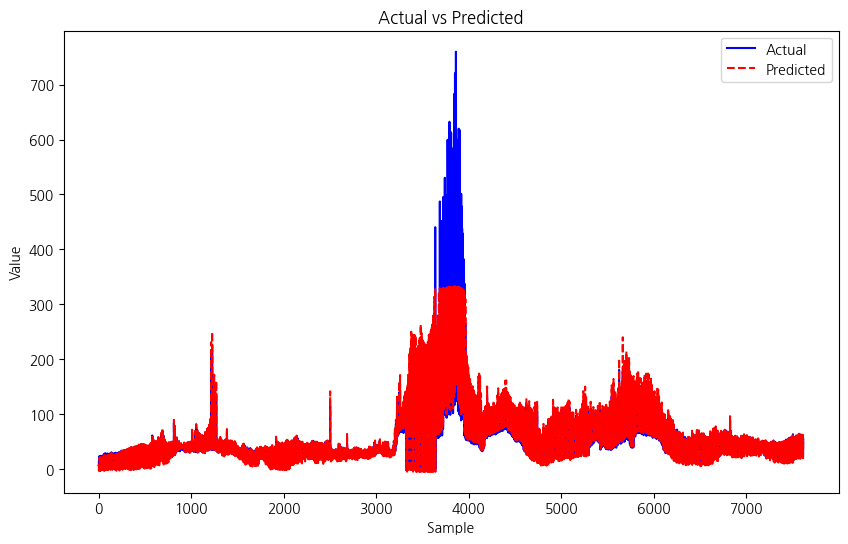

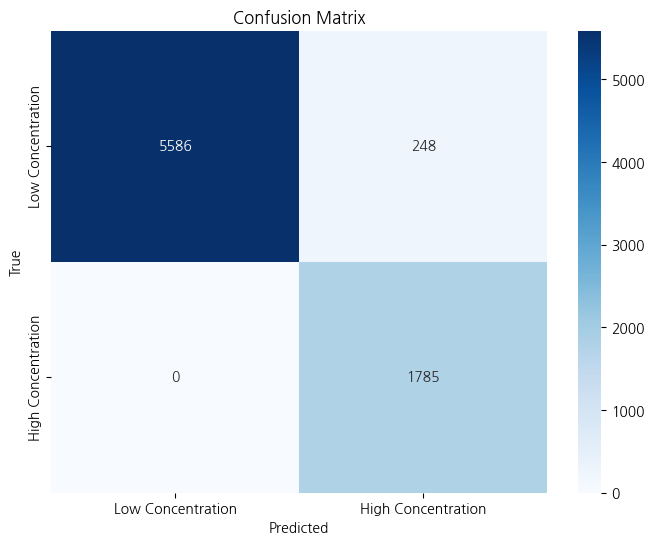

In [11]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns

#민감도를 기준으로 최적의 파라미터 설정
best_params = best_result_sensitivity['params']
model = TransformerRegression(X_train.shape[2], 1, num_encoder_layers=best_params['num_encoder_layers'], nhead=best_params['nhead'], hidden_dim=best_params['hidden_dim'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 데이터 로드 및 전처리 함수 정의
def load_and_preprocess_data(train_path, test_path):
    # 데이터 불러오기
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # 특성과 타겟 변수 분리 및 전처리
    X_train = train_data.drop(columns=["관측미세먼지", "경과일", "경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
    X_test = test_data.drop(columns=["관측미세먼지", "경과일", "경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

    # 스탠다드 스케일링
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Tensor로 변환 및 차원 변경
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    # DataLoader 정의
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    return train_loader, X_test, y_test

# 각 지역의 데이터셋 경로
regions = ["seoul", "ulsan", "incheon", "gwangju", "daejeon", "daegu"]
train_loaders = {}
X_tests = {}
y_tests = {}

for region in regions:
    train_path = f"/content/drive/MyDrive/train_{region}.csv"
    test_path = f"/content/drive/MyDrive/test_{region}.csv"
    train_loader, X_test, y_test = load_and_preprocess_data(train_path, test_path)

    train_loaders[region] = train_loader
    X_tests[region] = X_test
    y_tests[region] = y_test

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Region: seoul, Epoch [1/10], Loss: 108.3374
Region: seoul, Epoch [2/10], Loss: 59.1340
Region: seoul, Epoch [3/10], Loss: 53.5514
Region: seoul, Epoch [4/10], Loss: 47.6218
Region: seoul, Epoch [5/10], Loss: 40.3777
Region: seoul, Epoch [6/10], Loss: 49.3803
Region: seoul, Epoch [7/10], Loss: 41.0868
Region: seoul, Epoch [8/10], Loss: 37.9196
Region: seoul, Epoch [9/10], Loss: 42.4275
Region: seoul, Epoch [10/10], Loss: 42.1075
Region: seoul
Total number of high concentration samples: 1785
Number of correctly identified high concentration samples: 1785
Number of high concentration samples missed: 0
Sensitivity (Recall) for high concentration data: 1.0000
Total number of low concentration samples: 5834
Number of correctly identified low concentration samples: 5473
Number of low concentration samples missed: 361
Sensitivity (Recall) for low concentration data: 0.9381


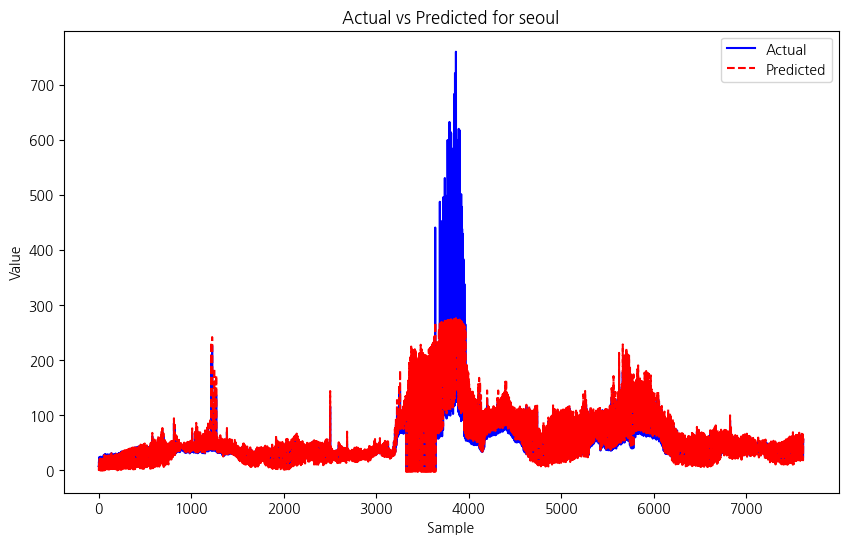

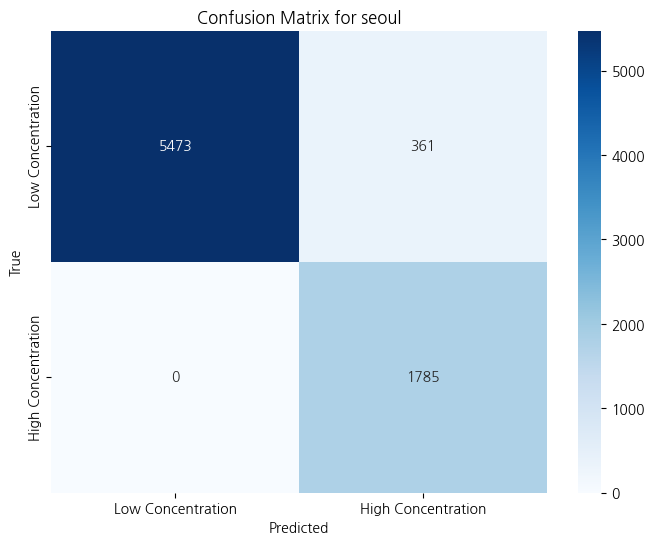

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Region: ulsan, Epoch [1/10], Loss: 52.6438
Region: ulsan, Epoch [2/10], Loss: 18.8164
Region: ulsan, Epoch [3/10], Loss: 22.7763
Region: ulsan, Epoch [4/10], Loss: 17.2717
Region: ulsan, Epoch [5/10], Loss: 21.4616
Region: ulsan, Epoch [6/10], Loss: 14.4377
Region: ulsan, Epoch [7/10], Loss: 18.1548
Region: ulsan, Epoch [8/10], Loss: 21.0516
Region: ulsan, Epoch [9/10], Loss: 19.3161
Region: ulsan, Epoch [10/10], Loss: 13.3137
Region: ulsan
Total number of high concentration samples: 278
Number of correctly identified high concentration samples: 278
Number of high concentration samples missed: 0
Sensitivity (Recall) for high concentration data: 1.0000
Total number of low concentration samples: 3615
Number of correctly identified low concentration samples: 3342
Number of low concentration samples missed: 273
Sensitivity (Recall) for low concentration data: 0.9245


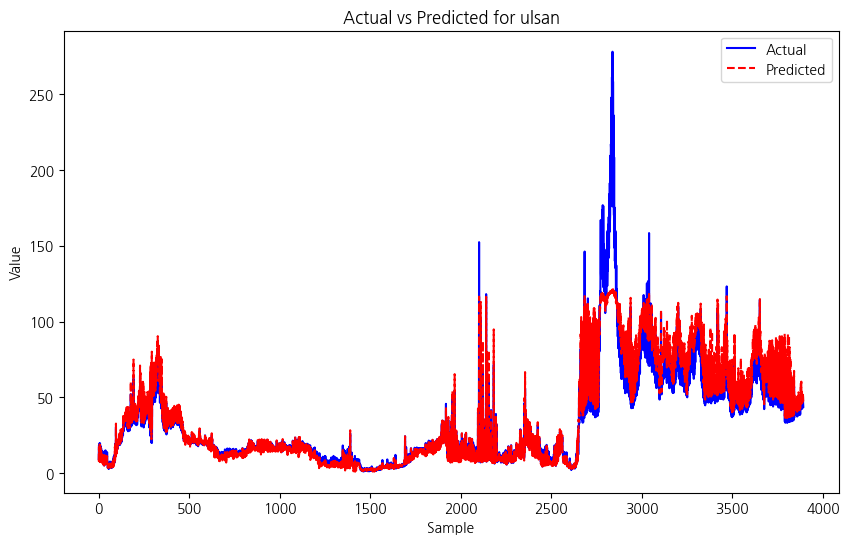

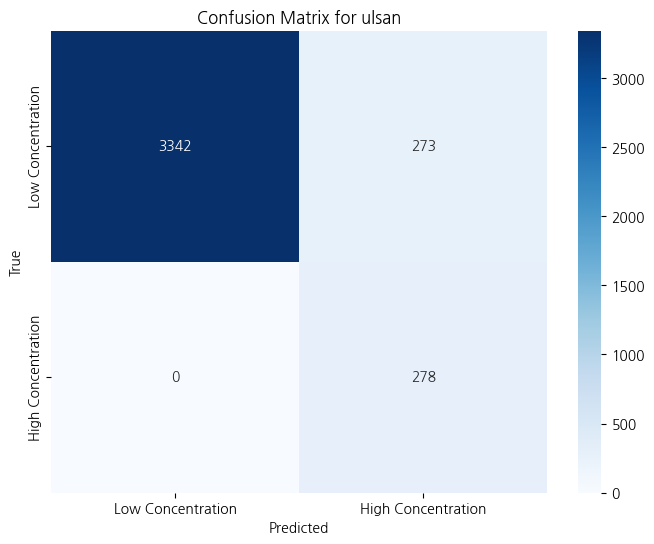

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Region: incheon, Epoch [1/10], Loss: 116.7468
Region: incheon, Epoch [2/10], Loss: 56.8448
Region: incheon, Epoch [3/10], Loss: 82.4686
Region: incheon, Epoch [4/10], Loss: 47.5840
Region: incheon, Epoch [5/10], Loss: 44.7406
Region: incheon, Epoch [6/10], Loss: 35.4035
Region: incheon, Epoch [7/10], Loss: 30.4787
Region: incheon, Epoch [8/10], Loss: 28.2634
Region: incheon, Epoch [9/10], Loss: 34.9167
Region: incheon, Epoch [10/10], Loss: 25.8243
Region: incheon
Total number of high concentration samples: 750
Number of correctly identified high concentration samples: 750
Number of high concentration samples missed: 0
Sensitivity (Recall) for high concentration data: 1.0000
Total number of low concentration samples: 6771
Number of correctly identified low concentration samples: 6614
Number of low concentration samples missed: 157
Sensitivity (Recall) for low concentration data: 0.9768


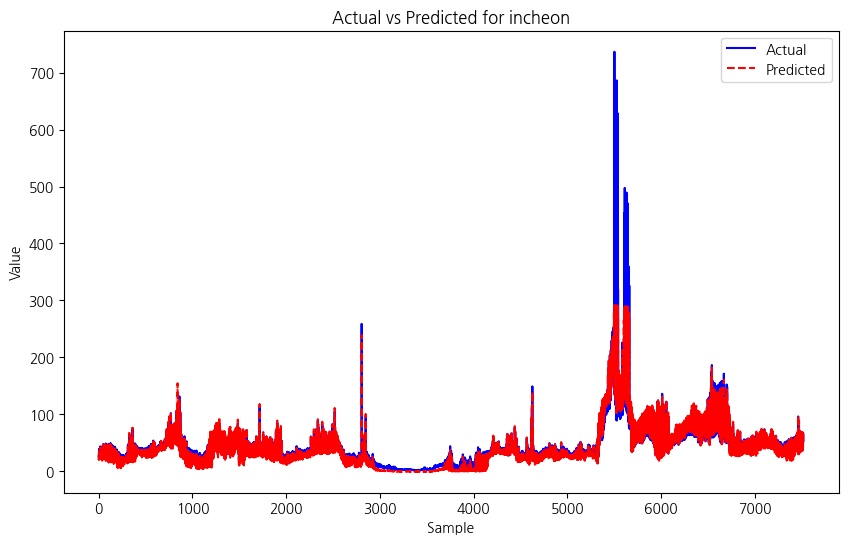

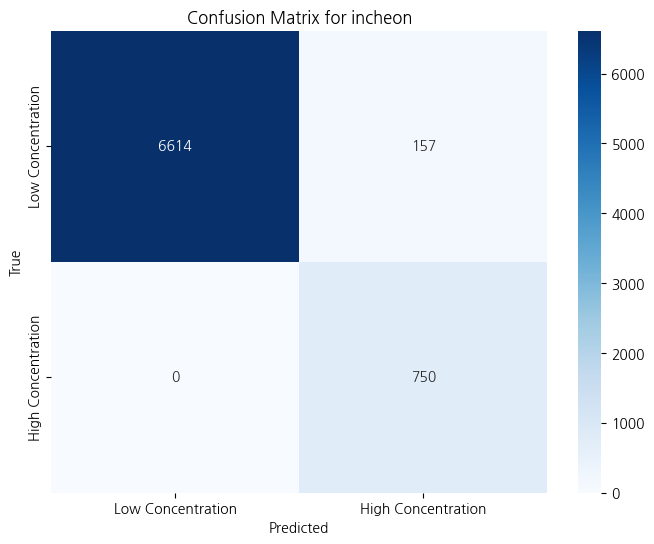

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Region: gwangju, Epoch [1/10], Loss: 90.0263
Region: gwangju, Epoch [2/10], Loss: 41.9881
Region: gwangju, Epoch [3/10], Loss: 33.4025
Region: gwangju, Epoch [4/10], Loss: 27.8225
Region: gwangju, Epoch [5/10], Loss: 24.7506
Region: gwangju, Epoch [6/10], Loss: 23.7590
Region: gwangju, Epoch [7/10], Loss: 22.7135
Region: gwangju, Epoch [8/10], Loss: 20.6430
Region: gwangju, Epoch [9/10], Loss: 21.1738
Region: gwangju, Epoch [10/10], Loss: 18.1898
Region: gwangju
Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3576
Number of high concentration samples missed: 4
Sensitivity (Recall) for high concentration data: 0.9989
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20427
Number of low concentration samples missed: 460
Sensitivity (Recall) for low concentration data: 0.9780


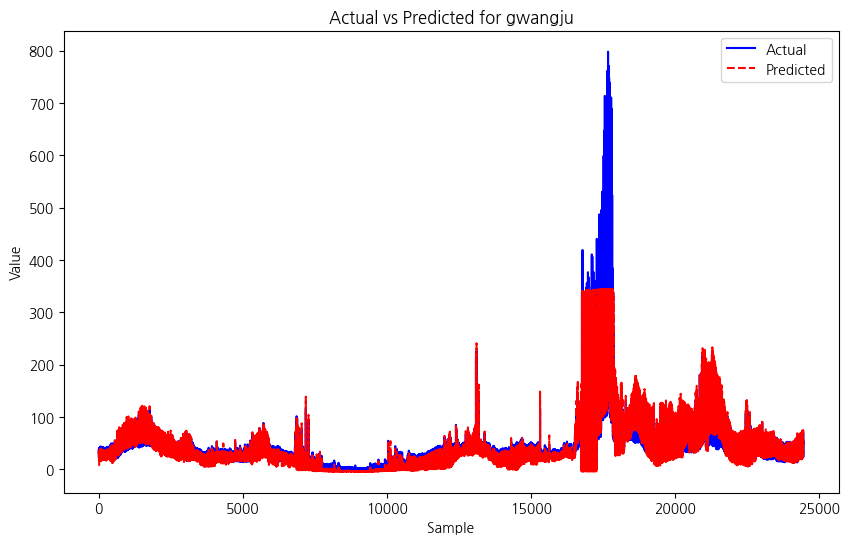

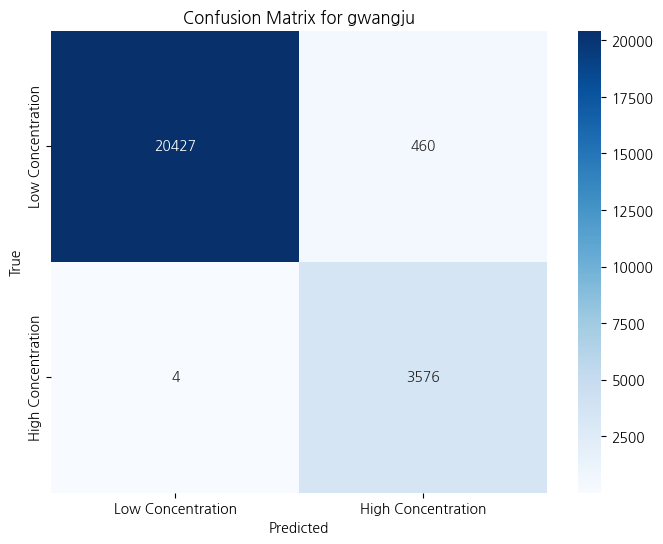

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Region: daejeon, Epoch [1/10], Loss: 150.4942
Region: daejeon, Epoch [2/10], Loss: 40.9567
Region: daejeon, Epoch [3/10], Loss: 29.3156
Region: daejeon, Epoch [4/10], Loss: 25.7392
Region: daejeon, Epoch [5/10], Loss: 22.9551
Region: daejeon, Epoch [6/10], Loss: 22.4585
Region: daejeon, Epoch [7/10], Loss: 20.9840
Region: daejeon, Epoch [8/10], Loss: 18.6955
Region: daejeon, Epoch [9/10], Loss: 19.4096
Region: daejeon, Epoch [10/10], Loss: 17.3603
Region: daejeon
Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3572
Number of high concentration samples missed: 8
Sensitivity (Recall) for high concentration data: 0.9978
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20553
Number of low concentration samples missed: 334
Sensitivity (Recall) for low concentration data: 0.9840


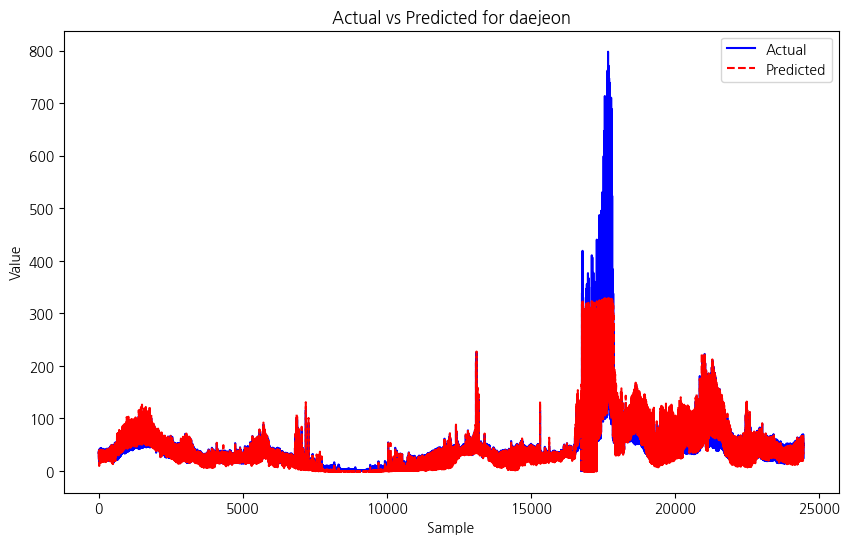

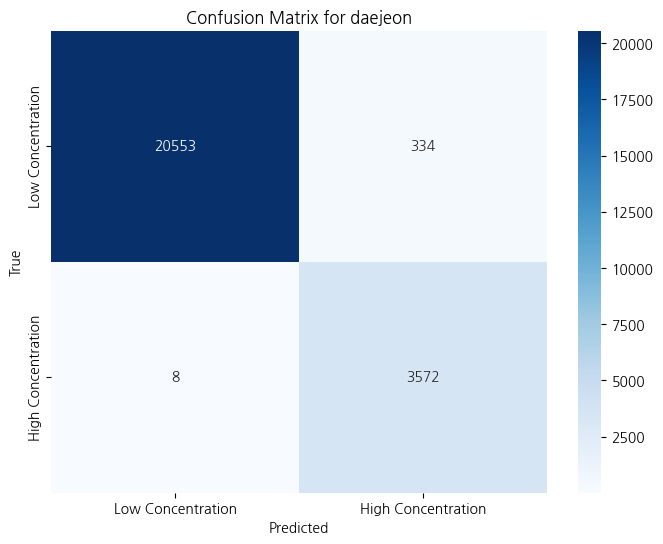

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Region: daegu, Epoch [1/10], Loss: 118.8649
Region: daegu, Epoch [2/10], Loss: 65.7446
Region: daegu, Epoch [3/10], Loss: 44.1041
Region: daegu, Epoch [4/10], Loss: 40.0911
Region: daegu, Epoch [5/10], Loss: 51.0860
Region: daegu, Epoch [6/10], Loss: 36.9509
Region: daegu, Epoch [7/10], Loss: 35.8778
Region: daegu, Epoch [8/10], Loss: 140.2530
Region: daegu, Epoch [9/10], Loss: 62.7787
Region: daegu, Epoch [10/10], Loss: 41.2571
Region: daegu
Total number of high concentration samples: 728
Number of correctly identified high concentration samples: 728
Number of high concentration samples missed: 0
Sensitivity (Recall) for high concentration data: 1.0000
Total number of low concentration samples: 5759
Number of correctly identified low concentration samples: 5651
Number of low concentration samples missed: 108
Sensitivity (Recall) for low concentration data: 0.9812


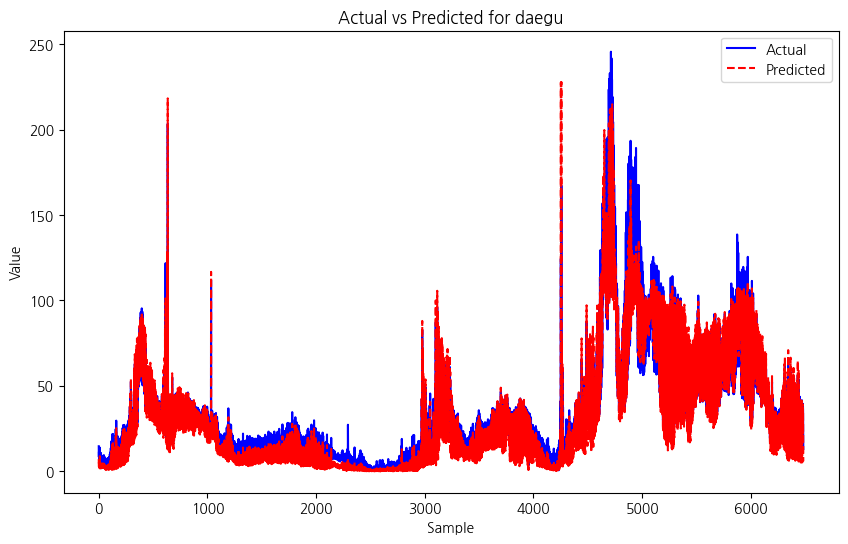

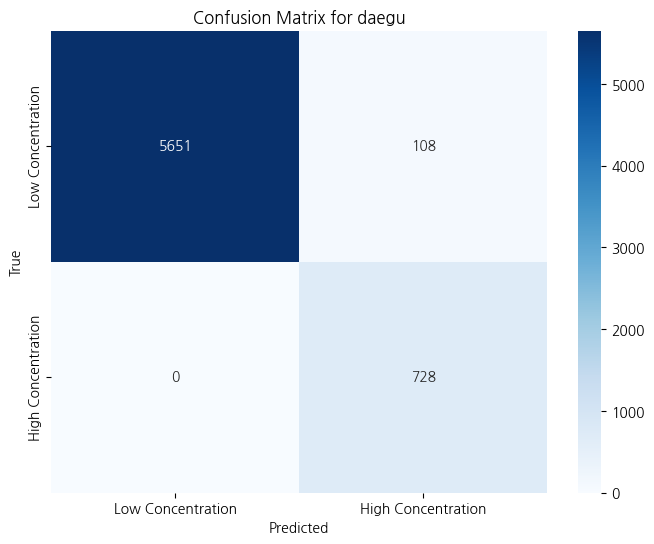

In [13]:
def train_and_evaluate_model(region, train_loader, X_test, y_test, best_params, num_epochs=10):
    model = TransformerRegression(
        input_dim=X_train.shape[2],
        output_dim=1,
        num_encoder_layers=best_params['num_encoder_layers'],
        nhead=best_params['nhead'],
        hidden_dim=best_params['hidden_dim'],
        dropout=best_params['dropout']
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Region: {region}, Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().numpy()
        y_pred = y_pred.squeeze()

    y_pred_classes = (y_pred >= 81).astype(int)
    y_test_classes = (y_test.squeeze().numpy() >= 81).astype(int)

    sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
    sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    tn, fp, fn, tp = conf_matrix.ravel()

    print(f'Region: {region}')
    print(f'Total number of high concentration samples: {tp + fn}')
    print(f'Number of correctly identified high concentration samples: {tp}')
    print(f'Number of high concentration samples missed: {fn}')
    print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')
    print(f'Total number of low concentration samples: {tn + fp}')
    print(f'Number of correctly identified low concentration samples: {tn}')
    print(f'Number of low concentration samples missed: {fp}')
    print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.squeeze().cpu(), label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for {region}')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {region}")
    plt.show()

regions = ["seoul", "ulsan", "incheon", "gwangju", "daejeon", "daegu"]

for region in regions:
    train_path = f"/content/drive/MyDrive/train_{region}.csv"
    test_path = f"/content/drive/MyDrive/test_{region}.csv"
    train_loader, X_test, y_test = load_and_preprocess_data(train_path, test_path)
    train_and_evaluate_model(region, train_loader, X_test, y_test, best_result_sensitivity['params'])